In [85]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError,RootMeanSquaredError


from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [86]:
drop_list=["Date","Open","High","Low","Close","Volume","SMA_7","SMA_14","EMA_7","EMA_14","RSI","Stoch_RSI","Upper_BB","Lower_BB","MACD"]
# drop_list=["Date","Open","High","Low","Close","Volume","SMA_14","EMA_14"]
train_df = pd.read_csv('data/train.csv').drop(drop_list,axis=1)
val_df = pd.read_csv('data/val.csv').drop(drop_list,axis=1)
test_df = pd.read_csv('data/test.csv').drop(drop_list,axis=1)

print(train_df.shape, val_df.shape, test_df.shape)

(2246, 1) (642, 1) (294, 1)


## `DataWindow` class 

In [87]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=64
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [88]:
def compile_and_fit(model, window, patience=3, max_epochs=100):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
        # RootMeanSquaredError
        # MeanAbsoluteError
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping]
                       )
    
    return history

In [89]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

In [90]:
multi_window = DataWindow(input_width=7, label_width=7, shift=1,label_columns=['Adj Close'])

In [91]:
Train_performance = {}
Test_performance = {}

## LSTM model 

In [92]:
lstm_model = Sequential([
    LSTM(150, return_sequences=True, activation='relu'),
    LSTM(150, activation='relu'),
    Dense(150, activation='relu'),
    Dense(1),
])

history = compile_and_fit(lstm_model, multi_window)

Train_performance['LSTM'] = lstm_model.evaluate(multi_window.train, verbose=0)
Test_performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)
print(Train_performance)
print(Test_performance)

Epoch 1/100
35/35 [==============================] - 3s 24ms/step - loss: 10598707.0000 - mean_absolute_error: 1780.5065 - val_loss: 8864349.0000 - val_mean_absolute_error: 2278.5359
Epoch 2/100
35/35 [==============================] - 1s 19ms/step - loss: 177064.9688 - mean_absolute_error: 201.0220 - val_loss: 4192812.2500 - val_mean_absolute_error: 1467.7018
Epoch 3/100
35/35 [==============================] - 1s 18ms/step - loss: 135560.4531 - mean_absolute_error: 180.1354 - val_loss: 4292253.0000 - val_mean_absolute_error: 1595.0016
Epoch 4/100
35/35 [==============================] - 1s 18ms/step - loss: 134341.7500 - mean_absolute_error: 183.3598 - val_loss: 3736388.2500 - val_mean_absolute_error: 1425.2275
Epoch 5/100
35/35 [==============================] - 1s 18ms/step - loss: 133473.6094 - mean_absolute_error: 174.5506 - val_loss: 3634758.2500 - val_mean_absolute_error: 1374.7208
Epoch 6/100
35/35 [==============================] - 1s 17ms/step - loss: 123301.8281 - mean_abso

In [93]:
test_predict=lstm_model.predict(test_df)
test_predict.shape

10/10 [==============================] - 0s 2ms/step


(294, 1)

In [96]:
test_predict[:10]

array([[477.6893 ],
       [479.64304],
       [492.88318],
       [447.2148 ],
       [445.9901 ],
       [434.10187],
       [435.6735 ],
       [443.49045],
       [427.89883],
       [430.643  ]], dtype=float32)

In [100]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_df, predict_df)
print(mse)

541956525.6364158


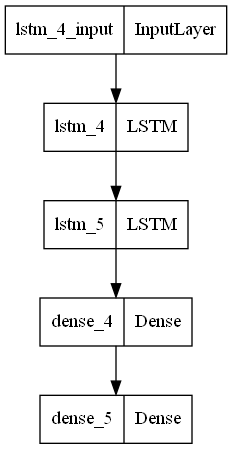

In [21]:
from keras.utils import plot_model
# tf.keras.utils.plot_model(lstm_model, to_file='Functional_API_model.png')
tf.keras.utils.plot_model(lstm_model)

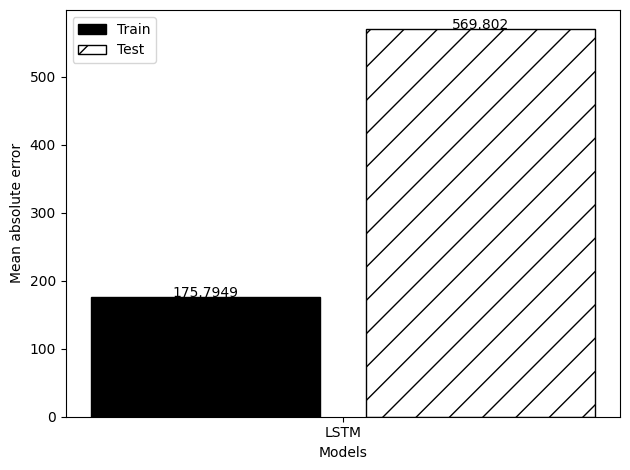

In [101]:
mae_Train = [v[1] for v in Train_performance.values()]
mae_test = [v[1] for v in Test_performance.values()]

x = np.arange(len(Test_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_Train, width=0.25, color='black', edgecolor='black', label='Train')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_Train):
    plt.text(x=index - 0.15, y=value, s=str(round(value, 4)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value, s=str(round(value, 4)), ha='center')

# plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=Test_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/BTC-MA_7.png', dpi=300)